# Foundation models for zero-shot detection and segmentation

Based on [Ollama](https://github.com/ollama/ollama) project.

In [1]:
!curl -L https://ollama.com/download/ollama-linux-amd64 -o ollama
!chmod +x ollama

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   112  100   112    0     0    161      0 --:--:-- --:--:-- --:--:--   161
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  558M  100  558M    0     0  73.1M      0  0:00:07  0:00:07 --:--:-- 95.4M


In [2]:
import subprocess
subprocess.Popen(["./ollama", "serve"])
import time
time.sleep(3)

In [3]:
!./ollama pull llava

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
pulling 170370233dd5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling 170370233dd5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling 170370233dd5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling 170370233dd5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling 170370233dd5...   0% ▕▏  11 MB/4.1 GB                  pulling manifest 
pulling 170370233dd5...   1% ▕▏  38 MB/4.1 GB                  pulling manifest 
pulling 170370233dd5...   1% ▕▏  55 MB/4.1 GB                  pulling manifest 
pulling 170370233dd5...   2% ▕▏  76 MB/4.1 GB                  pulling manifest 
pulling 170370233dd5...   2% ▕▏  88 MB/4.1 GB                  pulli

In [4]:
!wget -q -O image.jpg https://github.com/ant-nik/neural_network_course/blob/main/practice_2_data/video_1_fixed/image_001.jpg?raw=true

In [5]:
%%writefile prompt.txt
List all entities on the image.
Split answer in two sections: LIST and EXPLANATION.
Put names of found entities into LIST section.
Put an explanation of the answer into EXPLANATION section.

Writing prompt.txt


In [6]:
!echo '{ "model": "llava", "prompt": "'`cat prompt.txt`'", "images": ["'`base64 -w 0 /content/image.jpg`'"], "stream": false}' > llava-request.json
!cat llava-request.json

{ "model": "llava", "prompt": "List all entities on the image. Split answer in two sections: LIST and EXPLANATION. Put names of found entities into LIST section. Put an explanation of the answer into EXPLANATION section.", "images": ["/9j/4AAQSkZJRgABAQEAkACQAAD/4QCuRXhpZgAASUkqAAgAAAAHABIBAwABAAAAAQAAABoBBQABAAAAYgAAABsBBQABAAAAagAAACgBAwABAAAAAgAAADEBAgANAAAAcgAAADIBAgAUAAAAgAAAAGmHBAABAAAAlAAAAAAAAACQAAAAAQAAAJAAAAABAAAAR0lNUCAyLjEwLjM0AAAyMDIzOjA0OjE3IDIwOjMzOjU1AAEAAaADAAEAAAABAAAAAAAAAP/hDM1odHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvADw/eHBhY2tldCBiZWdpbj0i77u/IiBpZD0iVzVNME1wQ2VoaUh6cmVTek5UY3prYzlkIj8+IDx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDQuNC4wLUV4aXYyIj4gPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4gPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIgeG1sbnM6eG1wTU09Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9tbS8iIHhtbG5zOnN0RXZ0PSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvc1R5cGUvUmVzb3VyY2VFdmVudCMiIHhtbG5zOmRjPSJodHRwOi8vc

In [7]:
!curl -o llava-reply.json http://localhost:11434/api/generate --data-binary "@llava-request.json"
!cat llava-reply.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  475k  100  1914  100  473k    125  31708  0:00:15  0:00:15 --:--:--   468
{"model":"llava","created_at":"2024-08-22T07:28:25.868598736Z","response":" LIST:\n1. Man \n2. Plastic bottle \n3. Ground \n4. Rocks \n5. Tree \n6. Bottle cap \n7. Trash bag (not visible, implied to be in the trash can)\n\nEXPLANATION:\nThe image shows a man outdoors, presumably on a hike or trail walk. He is bending over and appears to be either inspecting a bottle cap he found on the ground or picking it up for disposal. In front of him, there's a trash can with what looks like a clear plastic bottle inside. The environment includes natural elements such as rocks, a tree in the background, and a trail leading to more unexplored terrain. ","done":true,"done_reason":"stop","context":[733,16289,28793,733,5422,28733,28734,28793,13,13,1245,544,19810,356,27

In [8]:
%%writefile llama-prompt-prefix.txt
Extract text between LIST and EXPLANATION sections and consider it as TEXT in the instruction below.
Split answer in two parts: OUTPUT and INFO.
In OUTPUT section place TEXT between START and END markers without enumerations symbols and one entity per line.
Convert noun words in the OUTPUT to singular form.
Put any explanation of the answer to INFO section.


Writing llama-prompt-prefix.txt


In [9]:
import json

with open("llama-prompt-prefix.txt") as prompt_file:
    llama_prompt = prompt_file.read()
with open("llava-reply.json", "r") as llava_file:
    llama_prompt += json.loads(llava_file.read())["response"]
llama_prompt += "\n\nOUTPUT:\n\n"
with open("llama-prompt.txt", "w") as llama_prompt_file:
    llama_prompt_file.write(llama_prompt)

In [10]:
!cat llama-prompt.txt

Extract text between LIST and EXPLANATION sections and consider it as TEXT in the instruction below.
Split answer in two parts: OUTPUT and INFO.
In OUTPUT section place TEXT between START and END markers without enumerations symbols and one entity per line.
Convert noun words in the OUTPUT to singular form.
Put any explanation of the answer to INFO section.
 LIST:
1. Man 
2. Plastic bottle 
3. Ground 
4. Rocks 
5. Tree 
6. Bottle cap 
7. Trash bag (not visible, implied to be in the trash can)

EXPLANATION:
The image shows a man outdoors, presumably on a hike or trail walk. He is bending over and appears to be either inspecting a bottle cap he found on the ground or picking it up for disposal. In front of him, there's a trash can with what looks like a clear plastic bottle inside. The environment includes natural elements such as rocks, a tree in the background, and a trail leading to more unexplored terrain. 

OUTPUT:



In [11]:
%%writefile llama-prompt-prefix-2.txt
Extract all entities from the text after OUTPUT keyword.
Split answer in two parts: LIST and INFO.
In LIST section place entities names without any enumeration symbols (one entity per line).
Put any explanation of the answer to INFO section.


Writing llama-prompt-prefix-2.txt


In [12]:
import json

with open("llama-prompt-prefix-2.txt") as prompt_file:
    llama_prompt = prompt_file.read()
with open("llava-reply.json", "r") as llava_file:
    llama_prompt += json.loads(llava_file.read())["response"].replace("\"", "'")
llama_prompt += "\n\nOUTPUT:\n\n"
with open("llama-prompt-2.txt", "w") as llama_prompt_file:
    llama_prompt_file.write(llama_prompt)

In [13]:
!echo '{ "model": "llama3.1", "prompt": "'`cat llama-prompt-2.txt`'", "stream": false}' > llama_request_body.json
!cat llama_request_body.json

{ "model": "llama3.1", "prompt": "Extract all entities from the text after OUTPUT keyword. Split answer in two parts: LIST and INFO. In LIST section place entities names without any enumeration symbols (one entity per line). Put any explanation of the answer to INFO section. LIST: 1. Man 2. Plastic bottle 3. Ground 4. Rocks 5. Tree 6. Bottle cap 7. Trash bag (not visible, implied to be in the trash can) EXPLANATION: The image shows a man outdoors, presumably on a hike or trail walk. He is bending over and appears to be either inspecting a bottle cap he found on the ground or picking it up for disposal. In front of him, there's a trash can with what looks like a clear plastic bottle inside. The environment includes natural elements such as rocks, a tree in the background, and a trail leading to more unexplored terrain. OUTPUT:", "stream": false}


In [14]:
!./ollama pull llama3.1

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠋ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling 8eeb52dfb3bb...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 8eeb52dfb3bb...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 8eeb52dfb3bb...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 8eeb52dfb3bb...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 8eeb52dfb3bb...   0% ▕▏  22 MB/4.7 GB                  pulling manifest 
pulling 8eeb52dfb3bb...   1% ▕▏  38 MB/4.7 GB                  pulling manifest 
pulling 8eeb52dfb3bb...   1% ▕▏  45 MB/4.7 GB                  pulling manifest 
pulling 8eeb52dfb3bb...   1% ▕▏  59 MB/4.7 GB                  pulling manifest 
pulling 8eeb52dfb3bb...   2% ▕▏  80 MB/4.7 GB                  pulling manifest 
pullin

In [15]:
!curl --data-binary "@llama_request_body.json" -o llama_reply.json http://localhost:11434/api/generate
!cat llama_reply.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2718  100  1861  100   857     93     43  0:00:20  0:00:19  0:00:01   405
{"model":"llama3.1","created_at":"2024-08-22T07:29:54.592193385Z","response":"Here are the entities extracted from the text after the OUTPUT keyword:\n\n**LIST**\nMan\nPlastic bottle\nGround\nRocks\nTree\nBottle cap\nTrash bag \n\n**INFO**\nThe output contains a list of entities that are visually present or implied in the image scene. These entities are objects, locations, and materials found within the environment depicted.","done":true,"done_reason":"stop","context":[128009,128006,882,128007,271,30059,682,15086,505,279,1495,1306,32090,16570,13,28910,4320,304,1403,5596,25,28064,323,31871,13,763,28064,3857,2035,15086,5144,2085,904,52678,18210,320,606,5502,824,1584,570,10435,904,16540,315,279,4320,311,31871,3857,13,28064,25,220,16,13,2418,220,17,13,37108

In [22]:
import json
def print_json(filename: str) -> dict[str, any]:
    with open(filename, "r") as file:
        step2_response = json.loads(file.read())
    return step2_response["response"] if "response" in step2_response else step2_response

In [24]:
step2_response = print_json("llama_reply.json")
print(step2_response)

Here are the entities extracted from the text after the OUTPUT keyword:

**LIST**
Man
Plastic bottle
Ground
Rocks
Tree
Bottle cap
Trash bag 

**INFO**
The output contains a list of entities that are visually present or implied in the image scene. These entities are objects, locations, and materials found within the environment depicted.


In [29]:
objects = [item for item in step2_response.replace("*","").split("LIST")[1].split("INFO")[0].split("\n") if not item=='']
objects

['Man',
 'Plastic bottle',
 'Ground',
 'Rocks',
 'Tree',
 'Bottle cap',
 'Trash bag ']

In [30]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image = Image.open("image.jpg")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

In [31]:
# VERY important: text queries need to be lowercased + end with a dot
text = " . ".join([f"all {item}" for item in objects]).lower() + '.'
print(text)

all man . all plastic bottle . all ground . all rocks . all tree . all bottle cap . all trash bag .


In [32]:
# VERY important: text queries need to be lowercased + end with a dot
text = " . ".join([f"{item}" for item in objects]).lower() + '.'
print(text)

man . plastic bottle . ground . rocks . tree . bottle cap . trash bag .


In [33]:
inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.07,
    text_threshold=0.07,
    target_sizes=[image.size[::-1]]
)
results

[{'scores': tensor([0.8627, 0.8546, 0.5491, 0.4293, 0.4547, 0.3692, 0.2910, 0.3032, 0.2780,
          0.2839, 0.2775, 0.2554, 0.1135, 0.2741, 0.2446, 0.2435, 0.2484, 0.2738,
          0.1978, 0.2188, 0.2014, 0.2849, 0.2416, 0.2401, 0.2147, 0.1992, 0.1898,
          0.1828, 0.2536, 0.1790, 0.2014, 0.2157, 0.1673, 0.1670, 0.1978, 0.1476,
          0.1419, 0.1997, 0.1820, 0.0981, 0.1335, 0.2754, 0.2221, 0.1580, 0.1324,
          0.1066, 0.1136, 0.1571, 0.1243, 0.0842, 0.1102, 0.1127, 0.1362, 0.2089,
          0.1239, 0.1455, 0.1221, 0.1285, 0.1684, 0.1332, 0.1104, 0.1271, 0.0825,
          0.1467, 0.0884, 0.0772, 0.1149, 0.1098, 0.1822, 0.1321, 0.0983, 0.0890,
          0.1002, 0.1050, 0.1056, 0.1753, 0.0781, 0.1302, 0.0964, 0.1036, 0.0949,
          0.0825, 0.0948, 0.0993, 0.0766, 0.0991, 0.1008, 0.0828, 0.1208, 0.1698,
          0.2088, 0.0877, 0.0938, 0.1104, 0.0991, 0.0920, 0.0953, 0.1030, 0.0949,
          0.0806, 0.0767, 0.1015, 0.0905, 0.0782, 0.0819, 0.1161, 0.0740, 0.1599,
      

In [36]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [37]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.0 MB/s eta 0:00:00


In [38]:
labels = results[0]["labels"]
unique_classes = list(set(labels))
class_to_index_map = {
    item: unique_classes.index(item) for item in unique_classes
}
classes = [class_to_index_map[item] for item in results[0]["labels"]]

In [39]:
labels

['plastic bottle',
 'man',
 'tree',
 'tree',
 'ground rocks',
 'rocks',
 'rocks',
 'rocks',
 'rocks',
 'tree',
 'tree',
 'rocks',
 'rocks',
 'tree',
 'rocks',
 'trash bag',
 'rocks',
 'tree',
 'rocks',
 'rocks',
 'tree',
 'tree',
 'rocks',
 'rocks',
 'tree',
 'tree',
 'rocks',
 'tree',
 'ground rocks',
 'tree',
 'tree',
 'tree',
 'rocks',
 'tree',
 'tree',
 'tree',
 'rocks',
 'rocks',
 'tree',
 'tree',
 'tree',
 'tree',
 'tree',
 'tree',
 'tree',
 'tree',
 'tree',
 'tree',
 'tree',
 'tree',
 'rocks',
 'tree',
 'rocks',
 'ground rocks',
 'tree',
 'rocks',
 'tree',
 'ground',
 'tree',
 'rocks',
 'tree',
 'tree',
 'rocks',
 'rocks',
 'tree',
 'tree',
 'rocks',
 'rocks',
 'rocks',
 'rocks',
 'tree',
 'rocks',
 'tree',
 'tree',
 'rocks',
 'tree',
 'rocks',
 'tree',
 'tree',
 'rocks',
 'rocks',
 'tree',
 'ground',
 'tree',
 'tree',
 'rocks',
 'ground',
 'rocks',
 'rocks',
 'plastic rocks bottle cap trash bag',
 'rocks',
 'rocks',
 'ground tree',
 'tree',
 'tree',
 'tree',
 'tree',
 'rocks',


In [41]:
import cv2
import supervision
import numpy


box_annotator = supervision.BoxAnnotator()
label_annotator = supervision.LabelAnnotator()

image_boxes = supervision.Detections(
    xyxy=results[0]["boxes"].cpu().numpy(),
    class_id=numpy.array(classes, dtype=int)
)

#, 2, 3, 4])#results[0]["labels"]
"""
labels = [
    f"{class_id} {confidence:0.2f}"
    for confidence, class_id, boxes in results
]
"""
annotated_frame = box_annotator.annotate(scene=image.copy(),
                                         detections=image_boxes) #, labels=labels)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=image_boxes,
    labels=labels
)


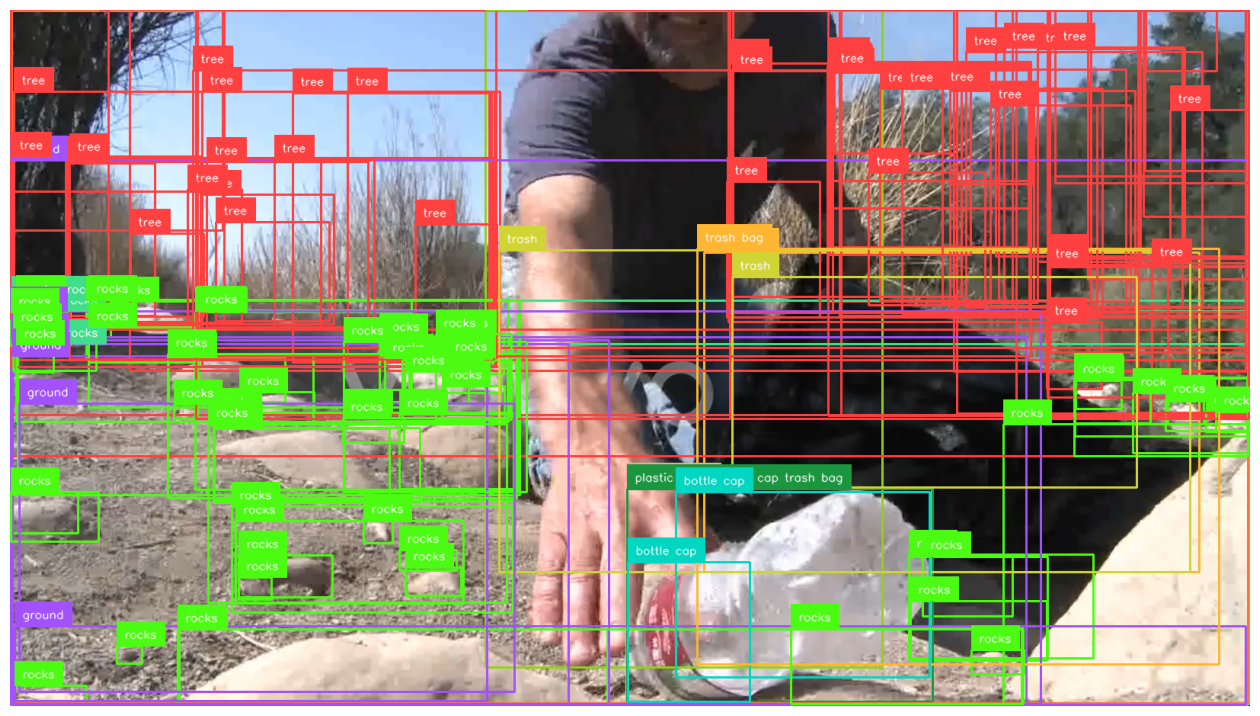

In [42]:
%matplotlib inline
supervision.plot_image(annotated_frame, (16, 16))

# Objects count by confidence score thresholds

In [51]:
with torch.no_grad():
    all_outputs = model(**inputs)

all_results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.17,
    text_threshold=0.17,
    target_sizes=[image.size[::-1]]
)

In [52]:
all_results

[{'scores': tensor([0.8627, 0.8546, 0.5491, 0.4293, 0.4547, 0.3692, 0.2910, 0.3032, 0.2780,
          0.2839, 0.2775, 0.2554, 0.2741, 0.2446, 0.2435, 0.2484, 0.2738, 0.1978,
          0.2188, 0.2014, 0.2849, 0.2416, 0.2401, 0.2147, 0.1992, 0.1898, 0.1828,
          0.2536, 0.1790, 0.2014, 0.2157, 0.1978, 0.1997, 0.1820, 0.2754, 0.2221,
          0.2089, 0.1822, 0.1753, 0.2088, 0.2179], device='cuda:0'),
  'labels': ['plastic bottle',
   'man',
   'tree',
   'tree',
   'ground',
   'rocks',
   'rocks',
   'rocks',
   'rocks',
   'tree',
   'tree',
   'rocks',
   'tree',
   'rocks',
   'trash bag',
   'rocks',
   'tree',
   'rocks',
   'rocks',
   'tree',
   'tree',
   'rocks',
   'rocks',
   'tree',
   'tree',
   'rocks',
   'tree',
   'rocks',
   'tree',
   'tree',
   'tree',
   'tree',
   'rocks',
   'tree',
   'tree',
   'tree',
   'rocks',
   'rocks',
   'tree',
   'rocks',
   'ground'],
  'boxes': tensor([[ 8.0978e+02,  6.2786e+02,  1.2106e+03,  9.0849e+02],
          [ 6.2428e+02,

In [45]:
x = numpy.linspace(0.01, 1, 100)
y = numpy.diff([len([x for x in filter(lambda x: x > threshold, all_results[0]["scores"])]) for threshold in x])

In [46]:
import plotly.express


plotly.express.line(x=x[1:], y=y)

In [47]:
plotly.express.histogram(y)

In [48]:
numpy.quantile(y, [0.01, 0.05, 0.1, 0.15, 0.2])

array([-144.1,  -41.2,  -11.6,   -5. ,   -4. ])

In [ ]:
5/99